# Subjective Class Compared to Income Class
### Cassandra Overney
This Jupyter notebook utilizes the [GSS dataset](https://gssdataexplorer.norc.org/) to study how respondents' family income relate to their self-identified classes. The main question I want to answer in this project is: **How does subjective class compare to income class?** I am personally interested in this topic because back in my hometown many people consider themselves middle class regardless of their income. I grew up confusing income class with subjective class. Now that I know more about their differences, I am curious to see whether a discrepancy between subjective and income class exists throughout America. Specific topics that are explored include:
- Can I replicate the figures from Hout's paper, ["How Class Works in Popular Conception"](http://ucdata.berkeley.edu/rsfcensus/papers/Hout-ClassIDJan07.pdf)? (starts on cell 17)
- How does the difference between income and subjective class compare to the differences between income and (1) the opinion on family income and (2) financial satisfaction? (starts on cell 26)
- Are there differences in subjective class depending on geographic location (i.e. urban vs rural)? (starts on cell 30)

## Data Cleaning

In [1]:
# Importing the necessary libraries
%matplotlib inline

import pandas as pd
import numpy as np

import itertools

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

from utils import decorate
from thinkstats2 import Pmf, Cdf

import thinkstats2
import thinkplot

import utils
from utils import decorate

from pandas_ml import ConfusionMatrix
import matplotlib.pyplot as plt

### GSS Dataset
All of the data I use in this notebook are from the GSS (General Social Survey) dataset. The General Social Survey (GSS) is a project of the independent research organization NORC at the University of Chicago, with principal funding from the National Science Foundation. The following terms need to be fulfilled to use GSS data:
- Proper citation of GSS and NORC 
- Responsible usage of the data
- Acknowledgement that NORC assumes no legal liability or responsibility for completeness, accuracy, usefulness, or fitness of the data

In [2]:
# Read in the GSS data and display the first 5 rows
def read_gss(dirname):
    """Reads GSS files from the given directory.
    
    dirname: string
    
    returns: DataFrame
    """
    dct = utils.read_stata_dict(dirname + '/GSS.dct')
    gss = dct.read_fixed_width(dirname + '/GSS.dat')
    return gss

gss = read_gss('Project1Data')
gss.head()

,year,rincome,region,srcbelt,partyid,polviews,satjob,class_,satfin,finrela,...,wrkstat,age,educ,sex,race,hompop,babies,preteen,teens,cohort
0,1972,0,3,3,2,0,3,3,3,3,...,1,23,16,2,1,1,0,0,0,1949
1,1972,0,3,3,1,0,0,3,2,4,...,5,70,10,1,1,2,0,0,0,1902
2,1972,0,3,3,3,0,2,2,1,3,...,2,48,12,2,1,4,0,1,1,1924
3,1972,0,3,3,1,0,1,3,3,3,...,1,27,17,2,1,2,0,0,0,1945
4,1972,0,3,3,0,0,0,2,1,4,...,7,61,12,2,1,2,0,0,0,1911


In [3]:
# Clean data by substituting nan for responses like no answer, don't know, or not applicable. 
gss.realinc.replace([0], np.nan, inplace=True)
gss['class_'].replace([5, 8, 9, 0], np.nan, inplace=True)
gss['hompop'].replace([99], np.nan, inplace=True)
gss['finrela'].replace([0, 8, 9], np.nan, inplace=True)
gss['satfin'].replace([0, 8, 9], np.nan, inplace=True)

### Descriptions of Relevant Variables

This section introduces all of the GSS variables that I utilize in this notebook. 

The `realinc` variable contains family income (one year prior to interview) in constant dollars with a base of 1986's dollar value. This variable is a recode created by GSS from the other income variables (`income72`, `income`, `income77`, `income82`, and `income86`). The question associated with `income` is "In which of these groups did your total family income, from all sources, fall last year before taxes? Just tell me the letter." (They are 12 groups for the `income` variable.) `realinc` has data from 1972 to 2016. More information can be found [here](http://gss.norc.org/Documents/reports/methodological-reports/MR064.pdf).  

The `class` variable contains subjective classes. The question is "If you were asked to use one of four names for your social class, which would you say you belong in: the lower class, the working class, the middle class, or the upper class?" The `class` variable includes data from 1972 to 2016 and has 3468 missing cases. Classes have four values:
- 1: lower class
- 2: working class
- 3: middle class
- 4: upper class
 
The `hompop` variable contains the household size of each respondent. According to the GSS Codebook Appendix D, "Household Enumeration Forms were completed for the chosen households prior to selection of the actual respondent", which means that it wasn't a formal question answered by the respondents. The `homepop` variable includes data from 1972 to 2016 and has 6 missing cases.

The `year` variable corresponds to the year of interview. This value is recorded automatically for every respondent, so there are no missing cases. 

The `age` variable is pretty-self explanatory. It includes data from 1972 to 2016 and has 221 missing cases.  

The `wrkstat` variable contains the respondents' labor force status. The question is "Last week were you working full time, part time, going to school, keeping house, or what?" The `wrkstat` variables includes data from 1972 to 2016 and has 19 missing cases. There are eight possible values:
- 1: working fulltime
- 2: working parttime
- 3: temp not working
- 4: unempl, laid off
- 5: retired
- 6: school
- 7: keeping house
- 8: other

The `finrela` variable contains the respondents' opinions on family income. The question is "Compared with American families in general, would you say your family income is far below average, below average, average, above average, or far above average?" The `finrela` variable includes data from 1972 to 2016 and has 5001 missing cases. There are five possible values:
- 1: far below average
- 2: below average
- 3: average
- 4: above average
- 5: far above average

The `satfin` variable contains the respondents' satisfaction with their current financial situations. The question is "We are interested in how people are getting along financially these days. So far as you and your family are concerned, would you say that you are pretty well satisfied with your present financial situation, more or less satisfied, or not satisfied at all?" The `satfin` variable includes data from 1972 to 2016 and has 4624 missing cases. There are three possible values:
- 1: satisfied
- 2: more or less satisfied
- 3: not at all satisfied

The `srcbelt` variable contains the sizes of the interview locations, which also applies to respondents' residences. The `srcbelt` variable includes data from 1972 to 2016 and has 0 missing cases because it is automatically recorded for every respondent. There are six possible values:
- 1: 12 lrgst smsa's (smsa stands for Standard Metropolitan Statistical Area)
- 2: Smsa's 13-100
- 3: Suburb, 12 lrgst
- 4: Suburb, 13-100
- 5: Other urban
- 6: Other rural

## Single Variable Explorations
To begin, I visualize the distribution of real incomes in order to gain a better understanding of the `realinc` variable. The other variables will not be independently explored since they are categorical and have fewer possible values. 

In [4]:
# Save realinc data as Pandas Series
all_real_incomes = gss['realinc'] 
all_real_incomes_scaled = all_real_incomes/1000 # scale real incomes for visualization purposes
all_classes = gss['class_']

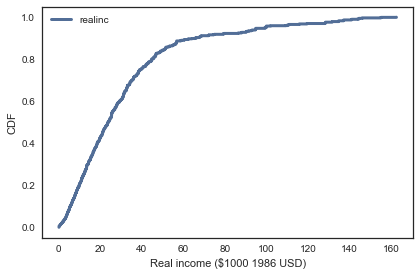

In [5]:
# Plot the CDF of real incomes
real_incomes_cdf = thinkstats2.Cdf(all_real_incomes_scaled, label='realinc')
thinkplot.Cdf(real_incomes_cdf)
decorate(xlabel='Real income ($1000 1986 USD)', ylabel='CDF')

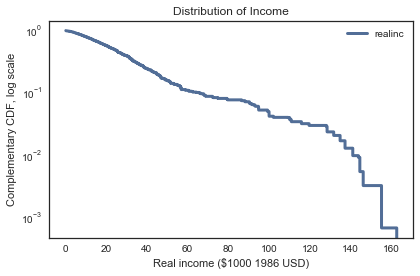

In [6]:
# Plot the complementary CDF to determine whether the distribution of real income is exponential
thinkplot.cdf(real_incomes_cdf, label='realinc', complement=True)

decorate(title='Distribution of Income', 
         xlabel='Real income ($1000 1986 USD)', 
         ylabel='Complementary CDF, log scale',
         yscale='log')

The complementary CDF looks relatively straight, which indicates that the distribution of real incomes may be exponential. I originally expected a Pareto distribution, but since GSS cuts off the power law tail by grouping respondent incomes, the "rich get richer" dynamics are lost. 

## Comparing Income and Subjective Class 
### Method #1
After single variable explorations, I convert real incomes into income classes. Method 1 is a simple approach, which involves finding an income to income class conversion scale, making sure the values are adjusted for inflation, and then directly converting real incomes to income classes. 

According to [Investopedia](https://www.investopedia.com/financial-edge/0912/which-income-class-are-you.aspx), in 2017, middle class corresponded to incomes between \$40,500 and \$122,000; lower class corresponded to incomes below \$40,500; and upper class corresponded to incomes above \$122,000. The article does not mention working class, so I just split the lower class. Working class is between \$14,000 and \$40,500, and lower class is below \$14,000.

From there, I use an [inflation calculator](https://www.usinflationcalculator.com/) to translate my 2017 income class values to 1986 amounts. As a result, lower class is below \$6,259.79; working class is between \$6,259.79 and \$18,108.68; middle class is between \$18,108.68 and \$54,549.61; and upper class is above \$54,549.61.

Now I can convert income into income classes using the same key as the subjective class variable. 

In [7]:
# Go through each income, find out which income class it is, and append the class to an array
calculated_classes = []
for income in all_real_incomes:
    if income > 54549.61:
        calculated_classes.append(4) # upper class
    elif income > 18108.68:
        calculated_classes.append(3) # middle class
    elif income > 6259.79:
        calculated_classes.append(2) # working class
    elif income <= 6259.79:
        calculated_classes.append(1) # lower class
calculated_classes = pd.Series(calculated_classes)
print(calculated_classes.head()) # printing to make sure it is in the right structure

0    3
1    3
2    3
3    3
4    3
dtype: int64


Since the income class and subjective class series have the same values, I can plot two side-by-side histograms to compare the distributions of income and subjective class. These histograms have the different classes on the x-axis (lower, working, middle, upper) and frequency on the y-axis. 

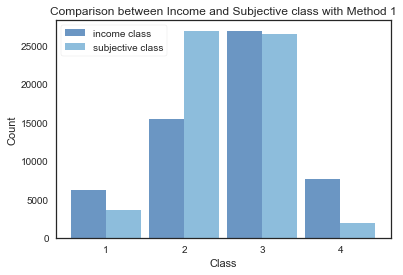

In [8]:
# Plot simple histograms for comparison
calculated_classes_hist = thinkstats2.Hist(calculated_classes, label='income class')
classes_hist = thinkstats2.Hist(all_classes, label='subjective class')
width = 0.45
thinkplot.PrePlot(2)
thinkplot.Hist(calculated_classes_hist, align='right', width=width)
thinkplot.Hist(classes_hist, align='left', width=width)
thinkplot.Config(title='Comparison between Income and Subjective class with Method 1', xlabel='Class', ylabel='Count', xticks=[1, 2, 3, 4])

It seems like most people consider themselves to be part of the working or middle classes. For the upper and lower classes, the frequency of subjective class is lower than the frequency of income class. The opposite difference can be seen in the working class (more people identify as working class than their income may suggest). These discrepancies suggest that income may not be the only factor that determines class. 

These observations can be beautifully summarized by a quote from the Urban Institute report titled [“The Growing Size and Incomes of the Upper Middle Class”](https://www.urban.org/sites/default/files/publication/81581/2000819-The-Growing-Size-and-Incomes-of-the-Upper-Middle-Class.pdf) by Stephen Rose, “because people tend to live in communities with similar incomes, they view themselves as being near the middle because their neighbors’ circumstances are similar to their own even if their incomes are significantly below or above the US median.”



### Method #2
Method 2 involves a more thorough way of calculating income class. Instead of taking one income-to-class conversion scale from 2017 and adjusting the values to 1986 dollars, I consider the fact that the cutoffs between the different income classes could vary year to year even after accounting for inflation. I did some more research on income classes and found the following information:
- Income data can be adjusted for inflation using the Consumer Price Index Research Series (CPI-U-RS), which is important for measures of absolute progress over time.
- Income class can be found by examining the proportion of a given income to the annual median household income. 
    - Middle class means earning between 2/3 and double the median household income.
    - The lower income group can be divided into lowest-income households and lower-middle income households (working class). Lower class means earning less than half of the median. Working class means earning between 1/2 and 2/3 the median. 
    - Upper class means earning more than double the median.
- It might be useful to adjust incomes for household size and then scale them to reflect a household size of three. 

The most recent data in GSS is from 2016, which means that the most recent income data is from 2015. As a result, I convert the real income data to constant 2015 dollars and then adjust them for household size. 

I obtain yearly median incomes (1971 to 2015) in 2015 dollars from the Census Bureau. The median household size from 1971 to 2015 is 3, so I don't need to adjust the medians for household size. To find the income classes, I compute the proportions between respondent incomes and median incomes (matched by year) and then compare the proportions to the conversion scale I mentioned above. 

In [9]:
# Read in median income data from a Excel file
median_income_file = 'Project1Data/median_income.xls'
median_income_df = pd.read_excel(median_income_file, index_col=None, na_values=['NA'], usecols="M").iloc[1:47]
# Generate list of years as strings
years = list(range(2015, 1970, -1))
# Add another 2013 to account for two 2013 median incomes
years.insert(2, '2013_2') 
# Set the index to years
median_income_df.index = years 
# Drop the first 2013 (has higher SE)
median_income_df = median_income_df.drop(median_income_df.index[[2]]) 
median_income_df.head()

,Median income (dollars)
2015,56516
2014,53718
2013,52850.1
2012,52665.9
2011,52750.6


In [10]:
# Convert realinc data to constant 2015 dollars
cpi_ratio = 348.9/168.6 # CPI-U-RS taken from Census Bureau, ratio is 2015 CPI to 1986 CPI
real_incomes_2015 = all_real_incomes*cpi_ratio

In [11]:
# Adjust income for household size of 3
all_household_sizes = gss['hompop']
adjusted_real_incomes_2015 = (real_incomes_2015/(all_household_sizes**0.5))*(3**0.5)

In [12]:
# Calculate income classes
income_years = gss['year'] - 1 # minus 1 since respondents report last year's income
income_classes = []
# Iterate through each income year (one for each respondent)
for index, resp_yr in enumerate(income_years):
    # Get the median based on the resp_yr
    temp_median = median_income_df.loc[resp_yr]['Median income (dollars)']
    # Get respondent income
    temp_income = adjusted_real_incomes_2015[index]
    # Find the proportion of income to median income
    temp_prop = temp_income/temp_median
    if temp_prop > 2:
        income_classes.append(4) # upper
    elif temp_prop >= (2/3):
        income_classes.append(3) # middle 
    elif temp_prop >= (1/2):
        income_classes.append(2) # working
    elif temp_prop < (1/2):
        income_classes.append(1) # lower
    else:
        income_classes.append(np.nan)

income_classes = pd.Series(income_classes)
print(income_classes.head())

0    3.0
1    3.0
2    3.0
3    3.0
4    4.0
dtype: float64


Just as I did for method #1, I can plot two side-by-side histograms to compare the distributions of income and subjective class. These histograms have the different classes on the x-axis (lower, working, middle, upper) and frequency on the y-axis.

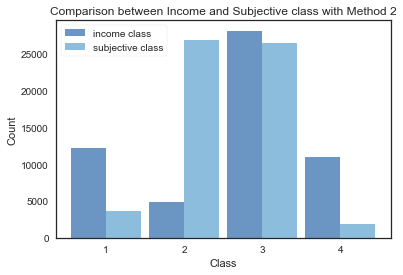

In [13]:
# Plot simple histograms for comparison
income_classes_hist = thinkstats2.Hist(income_classes, label='income class')
classes_hist = thinkstats2.Hist(all_classes, label='subjective class')
width = 0.45
thinkplot.PrePlot(2)
thinkplot.Hist(income_classes_hist, align='right', width=width)
thinkplot.Hist(classes_hist, align='left', width=width)
thinkplot.Config(title='Comparison between Income and Subjective class with Method 2', xlabel='Class', ylabel='Count', xticks=[1, 2, 3, 4])

The histogram from method #2 has some similarities and differences with the histogram from method #1. 

Similarities:
- Most people consider themselves to be part of the working or middle classes.
- Most respondents are in the middle income class.
- For the upper and lower classes, the frequency of subjective class is lower than the frequency of income class.
- For the working class, more people identify as working class than their income may suggest.

Differences:
- The frequency of lower income class in the updated histogram is much higher, while the frequency of working income class is much lower. This is probably due to the fact that the range for working income class is more narrow in method 2 compared to my estimation in method 1. 
- The differences between income and subjective class for all classes are greater in the second histogram compared to the first. 

Even with these differences, similar discrepancies can be observed from method #2, which supports the statement that income is probably not the only factor that determines class.

## Pairwise Comparisons with Confusion Matrix
A general comparison between income and subjective class is a good first step, but it would be more interesting to conduct pairwise comparisons to discover what classes respondents with a particular income identify as. One way to visualize pairwise comparisons is with a confusion matrix with predictions (income class) on the x-axis and actual values (subjective class) on the y-axis. Each cell of the 4\*4 matrix is colored by density. 

I create and plot a confusion matrix with subjective class and income class (from method #2). First, I write two important functions that I reference throughout the rest of the notebook. 

In [14]:
# The following function was adapted from a stack overflow thread 
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True, y_label='True plot', x_label='Predicted label'):
    """
    Given the values of a confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Citiation
    ---------
    https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels

    """
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm2 = cm.astype('float') / cm.sum()

    thresh = cm.max() / 2

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:,}\n{:0.1f}%".format(cm[i, j], cm2[i, j]*100),
                     horizontalalignment="center",
                     verticalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     verticalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel(y_label, labelpad=10)
    plt.xlabel(x_label, labelpad=10)
    plt.colorbar()
    plt.show()

In [15]:
# Function to find confusion matrix and convert to numpy arrays
def get_cm(actual, prediction):
    """
    Create confusion matrix from two series
    
    actual: contains values along y-axis
    prediction: contains values along x-axis
    cm: numpy array form of confusion matrix
    """
    confusion_matrix = ConfusionMatrix(actual, prediction)
    # Convert confusion matrix into data frame and then numpy arrays
    cm_df = confusion_matrix.to_dataframe()
    cm = cm_df.values
    return cm

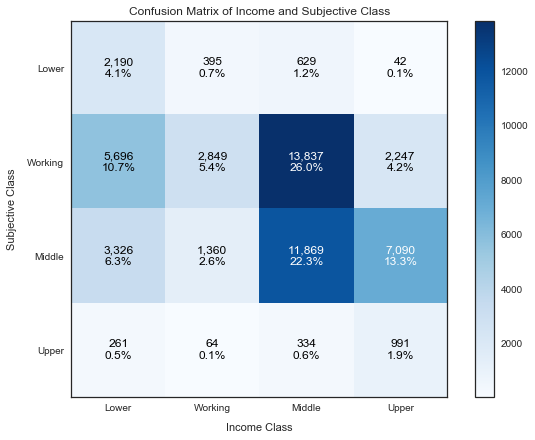

In [16]:
# Make confusion matrix of subjective class and income class
cm = get_cm(all_classes, income_classes)
# Plot confusion matrix
plot_confusion_matrix(cm,['Lower', 'Working', 'Middle', 'Upper'],title='Confusion Matrix of Income and Subjective Class',cmap=None,normalize=True, y_label='Subjective Class', x_label='Income Class')

The following observations can be made regarding the above confusion matrix:
- Most of the subjective classes are working or middle class.
- Very few respondents proclaim themselves to be upper class even if their income classes are. 
- Respondents from the lower income class are more likely to consider themselves working class than lower or middle class.
- There are not many people in the working income class (also mentioned in method #2 histogram). Those who are mainly characterize themselves as working class.
- Most respondents lie in the middle income class and they mainly characterize themselves as either working or middle class (with working class being more common).
- Respondents from the upper income class are more likely to consider themselves middle and then working class compared to upper class.

The confusion matrix provides additional support that most respondents consider themselves as middle or working class. Furthermore, income does not indicate subjective class. However, there are differences in subjective class for each income class. For example, respondents in the lowest income class are more likely to consider themselves working class while respondents in the highest income class are more likely to consider themselves middle class.  

## Data Validation
After doing pairwise comparisons between income and subjective class, it is important to compare my findings with other sources. In 2007, Michael Hout at UC Berkeley published a paper, "How Class Works in Popular Conception", which delves into what factors Americans consider when identifying their class. The paper uses data from GSS and its Figure 1 shows the distribution of class identification for various family income ranges with a segmented bar graph. I decided to compare my findings with Hout's. First, I create a segmented bar graph with all of the respondents (discluding nans). The different income ranges include:
- 1: less than \$20,000
- 2: \$20,000-\$29,999
- 3: \$30,000-\$49,999
- 4: \$50,000-\$74,999
- 5: \$75,000-\$99,999
- 6: above \$100,000

I write two functions `find_income_ranges` and `create_bar_graph` since they are used a lot throughout the rest of this notebook. 

In [17]:
# Function to calculate income ranges
def find_income_ranges(incomes):
    """
    Iterate through incomes and convert into respecitve income ranges
    
    incomes: array of adjusted income values
    income_ranges: array of income range number
    """
    income_ranges = []
    for index, income in enumerate(incomes):
        if income >= 100000:
            income_ranges.append(6)
        elif income >= 75000:
            income_ranges.append(5)
        elif income >= 50000:
            income_ranges.append(4)
        elif income >= 30000:
            income_ranges.append(3)
        elif income >= 20000:
            income_ranges.append(2)
        elif income < 20000:
            income_ranges.append(1)
        else:
            income_ranges.append(np.nan)

    income_ranges = pd.Series(income_ranges)
    return income_ranges

In [18]:
# Function to create segmented bar graph
def create_bar_graph(cm, x_values, labels, x_label, y_label, title):
    """
    Create segmented bar graph with some style as Figure 1 in Hout's paper
    
    cm: confusion matrix
    x_values: names of each bar (i.e. income ranges)
    labels: names for each color (i.e. subjective class)
    x_label: name of x-axis
    y_label: name of y-axis
    title: name of figure
    """
    x_pos = [i for i, _ in enumerate(x_values)]
    
    total = cm.sum(axis=0)
    
    props = []
    for i in range(len(labels)-1, -1, -1):
        props.append(np.true_divide(cm[i,:], total) * 100)
        
    props = np.array(props)
    
    colors = ['gold', 'silver', '#CD853F', 'brown', 'orange']
    for i in range(0, len(labels)):
        if i < len(labels)-1:
            plt.barh(x_pos, props[i], height=0.8, label=labels[i], color=colors[i], 
                left=props[i+1:].sum(axis=0))
        else:
            plt.barh(x_pos, props[i], height=0.8, label=labels[i], color=colors[i])

    plt.yticks(x_pos, x_values)
    plt.xticks([0, 25, 50, 75, 100])
    locs, labels = plt.xticks()
    plt.xticks(locs[:], ['0%', '25%', '50%', '75%', '100%'])
    plt.grid()
    plt.ylabel(y_label, labelpad=10)
    plt.xlabel(x_label, labelpad=10)
    plt.title(title, pad=22)
    handles, labels = plt.gca().get_legend_handles_labels()
    order = range(len(labels)-1,-1,-1)
    plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc="upper center", bbox_to_anchor=(0.5, 1.10),
              ncol=len(labels))

    plt.show()

In [19]:
# Calculate income ranges from adjusted realinc data
all_income_ranges = find_income_ranges(adjusted_real_incomes_2015)
# Find confusion matrix with income_ranges and subjective classes
cm2 = get_cm(all_classes, all_income_ranges)

C:\ProgramData\Miniconda3\lib\site-packages\pandas_ml\confusion_matrix\abstract.py:66: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  df = df.loc[idx, idx.copy()].fillna(0)  # if some columns or rows are missing


The warning above is present because `all_income_ranges` has 6 possible values while `all_classes` has 4 possible values. I didn't fix this warning because it still works.   

### Figure 1: All Respondents

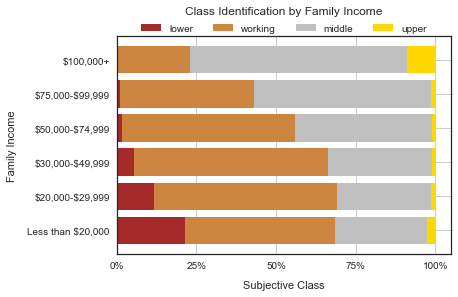

In [20]:
income_range_names = ['Less than \$20,000', '\$20,000-\$29,999', '\$30,000-\$49,999', '\$50,000-\$74,999', '\$75,000-\$99,999', '\$100,000+']
labels = ['upper', 'middle', 'working', 'lower']
create_bar_graph(cm2, income_range_names, labels, 'Subjective Class', 'Family Income', 'Class Identification by Family Income')

This segmented bar graph is another representation of the data within the confusion matrix but with income ranges instead of income classes. It seems like most respondents identify as working or middle class. As respondent income goes up, the distribution of subjective upper class rises. As respondent income goes down, the distribution of subjective lower class increases.

### Figure 2: Employed Respondents 25 Years or Older from 2000-2004
Now, I attempt to duplicate the figure in the paper mentioned above. Hout only includes employed respondents 25 years or older from 2000 to 2004, so I first need to create a subset of my `gss` dataframe. The `wrkstat` variable indicates employment status. I select for codes 1 to 3, which include working fulltime, working parttime, and temporarily not working. I also use another cpi ratio to convert `realinc` from 1986 dollars to 2004 dollars (instead of 2015 dollars). The paper does not mention adjusting for household size, so I do not include that step in the analysis.

In [21]:
# Select for respondents who answered survey 2000-2004, aged 25 years or older, and employed
sub_gss = gss[(gss['year'] >= 2000) & (gss['year'] <= 2004) & (gss['age'] >= 25) 
              & (gss['wrkstat'] <= 3)]
sub_real_incomes = sub_gss['realinc']
sub_classes = sub_gss['class_']
cpi_ratio2 = 277.5/168.6
sub_real_incomes_2004 = sub_real_incomes*cpi_ratio2

In [22]:
# Calculate income ranges
sub_income_ranges = find_income_ranges(sub_real_incomes_2004)
# Make sure indices of income ranges match with indices of subject class
sub_income_ranges.index = sub_classes.index
# Find confusion matrix with income_ranges and subjective classes
sub_cm = get_cm(sub_classes, sub_income_ranges)

C:\ProgramData\Miniconda3\lib\site-packages\pandas_ml\confusion_matrix\abstract.py:66: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  df = df.loc[idx, idx.copy()].fillna(0)  # if some columns or rows are missing


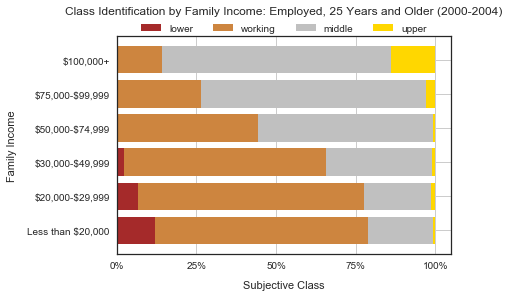

In [23]:
# Plot sub_cm as segmented bar graph
income_range_names = ['Less than \$20,000', '\$20,000-\$29,999', '\$30,000-\$49,999', '\$50,000-\$74,999', '\$75,000-\$99,999', '\$100,000+']
labels = ['upper', 'middle', 'working', 'lower']
create_bar_graph(sub_cm, income_range_names, labels, 'Subjective Class', 'Family Income', 'Class Identification by Family Income: Employed, 25 Years and Older (2000-2004)')

The segmented bar graph above is nearly identical to Hout's Figure 1. There are some slight differences in distributions. For example, in the \$20,000-\$29,999 income range, I found that the proportion of lower and working subjective class is around 77% instead of Hout's 75%. Even so, these differences are quite small and might be due to differing definitions of what it means to be employed and methods to adjust for inflation.

### Figure 3: Employed Respondents 25 Years or Older from 2000-2004 with Household Size Adjustment
After successfully replicating Hout's figure, I reintroduce the step in which I adjust incomes for household size. My goal for this sub-section is to see how the distribution of subjective class would change with a slight but potentially important modification to the data processing.  

In [24]:
sub_household_sizes = sub_gss['hompop']
sub_adjusted_real_incomes_2004 = (sub_real_incomes_2004/(sub_household_sizes**0.5))*(3**0.5)
# Calculate income ranges
sub_income_ranges2 = find_income_ranges(sub_adjusted_real_incomes_2004)
# Make sure indices of income ranges match with indices of subject class
sub_income_ranges2.index = sub_classes.index
# Find confusion matrix with income_ranges and subjective classes
sub_cm2 = get_cm(sub_classes, sub_income_ranges2)

C:\ProgramData\Miniconda3\lib\site-packages\pandas_ml\confusion_matrix\abstract.py:66: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  df = df.loc[idx, idx.copy()].fillna(0)  # if some columns or rows are missing


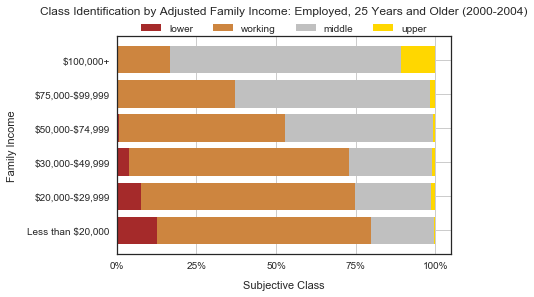

In [25]:
# Plot sub_cm2 as segmented bar graph
income_range_names = ['Less than \$20,000', '\$20,000-\$29,999', '\$30,000-\$49,999', '\$50,000-\$74,999', '\$75,000-\$99,999', '\$100,000+']
labels = ['upper', 'middle', 'working', 'lower']
create_bar_graph(sub_cm2, income_range_names, labels, 'Subjective Class', 'Family Income', 'Class Identification by Adjusted Family Income: Employed, 25 Years and Older (2000-2004)')

With household size adjustment, the segmented bar graph looks quite different. The distribution of working class increased for the \$100,000+, \$75,000-\$99,999, \$50,000-\$74,999, and \$30,000-\$49,999 income ranges. These differences confirm that Hout probably did not adjust his incomes for household size (he never explicitly stated whether he did or didn't). Household size is important to consider because a single person making \$50,000 per year is very different from a family of five making \$50,000 per year. It would be interesting to rerun all of Hout's analysis with household size adjustments.  

Overall, the "Data Validation" section illustrates how my analysis procedure compares to other people's. I was able to replicate Hout's "Class Identification by Family Income" figure and expand on one of his findings with household size adjustments. 

## Exploring Respondent Opinion of Family Income and Financial Satisfaction
GSS has two other variables, `finrela` and `satfin`, that connect to respondent opinions on their financial situations. In the following section, I compare the distribution of these variables within each income range. 

### Figure 1: Opinion of Family Income

In [26]:
# Starting with finrela which gives respondents' opinions on family income
all_finrelas = gss['finrela']
# Find confusion matrix with income_ranges and finrelas
cm3 = get_cm(all_finrelas, all_income_ranges)

C:\ProgramData\Miniconda3\lib\site-packages\pandas_ml\confusion_matrix\abstract.py:66: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  df = df.loc[idx, idx.copy()].fillna(0)  # if some columns or rows are missing


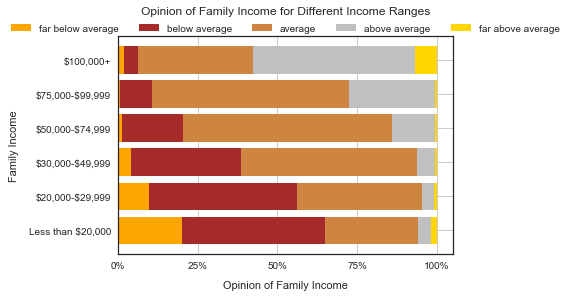

In [27]:
# Plot confusion matrix via segmented bar graph
income_range_names = ['Less than \$20,000', '\$20,000-\$29,999', '\$30,000-\$49,999', '\$50,000-\$74,999', '\$75,000-\$99,999', '\$100,000+']
labels = ['far above average', 'above average', 'average', 'below average', 'far below average']
create_bar_graph(cm3, income_range_names, labels, 'Opinion of Family Income', 'Family Income', 'Opinion of Family Income for Different Income Ranges')

The opinion of family income variable corresponds more closely to actual income compared to subjective class. For the last two income ranges, a majority of respondents consider their family incomes to be far below or below the American average income. Even so, respondents are more likely to consider their income to be below average or average even if their incomes are actually above average. For the highest income range, almost 40% of respondents think their incomes are average or even below average.  

### Figure 2: Financial Satisfaction

In [28]:
# Getting satfin variable which gives respondents' financial satisfaction level
all_satfins = gss['satfin']
# Find confusion matrix with income_ranges and satfins
cm4 = get_cm(all_satfins, all_income_ranges)
# Have to swap first and third rows since 1 means satisified instead of not at all
cm4[0], cm4[2] = cm4[2], np.array(cm4[0])

C:\ProgramData\Miniconda3\lib\site-packages\pandas_ml\confusion_matrix\abstract.py:66: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  df = df.loc[idx, idx.copy()].fillna(0)  # if some columns or rows are missing


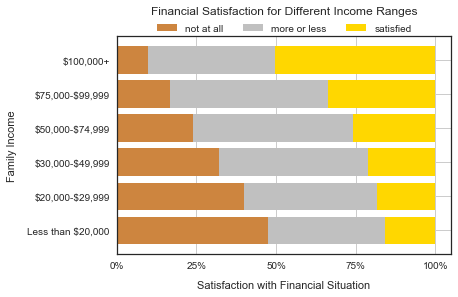

In [29]:
# Plot confusion matrix
income_range_names = ['Less than \$20,000', '\$20,000-\$29,999', '\$30,000-\$49,999', '\$50,000-\$74,999', '\$75,000-\$99,999', '\$100,000+']
labels = ['satisfied', 'more or less', 'not at all']
create_bar_graph(cm4, income_range_names, labels, 'Satisfaction with Financial Situation', 'Family Income', 'Financial Satisfaction for Different Income Ranges')

The financial satisfaction bar graph indicates that regardless of family income, respondents are more likely to say that they are more or less satisfied or satisfied with their current financial situations. Even in the lowest income range, the distribution of not at all satisfied does not exceed 50%. It is interesting how the not at all satisfied distribution gradually increases as the income decreases, while the satisfied distribution gradually increases as the income increases. 

While comparing the segmented bar graphs of subjective class, opinion of family income, and financial satisfaction, I found that all three variables are impacted by income. However, income is not the only deciding factor even for financial satisfaction. 

## Exploring Subjective Class and Income for Respondents living in Urban, Suburban, and Rural Areas  

The final analysis involves comparing how subjective class for each income range differs for varying `srcbelt` values. To determine which `srcbelt` groups to look at, I reference the `value_counts`. 

In [30]:
gss['srcbelt'].value_counts()

5    23583
4     9348
2     8670
6     8180
3     7113
1     5572
Name: srcbelt, dtype: int64

Based on the values with the highest counts, I select the groups Smsa's 13-100 (23% of urban respondents), Suburb, 13-100 (57% of suburban respondents), and Other rural (100% of rural respondents). I am not using Other urban because it seems too general compared to Standard Metropolitan Statistical Areas. Furthermore, I found that the urban and suburban distributions are all relatively similar to each other, so I can just chose one group from each geographical type for comparison purposes. 

I first group the respondents by `srcbelt` values and then generate a confusion matrix for each `srcbelt` type. 

In [31]:
# Turn income ranges into a column in gss
gss['income_ranges'] = all_income_ranges
# Group gss dataframe by srcbelt values
grouped_srcbelt = gss.groupby('srcbelt')

In [32]:
# Generate a confusion matrix for each srcbelt type
cms = []
for name, group in grouped_srcbelt:
    temp_classes = group['class_']
    temp_income_ranges = group['income_ranges']
    cms.append(get_cm(temp_classes, temp_income_ranges))

C:\ProgramData\Miniconda3\lib\site-packages\pandas_ml\confusion_matrix\abstract.py:66: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  df = df.loc[idx, idx.copy()].fillna(0)  # if some columns or rows are missing


### Figure 1: Smsa's 13-100

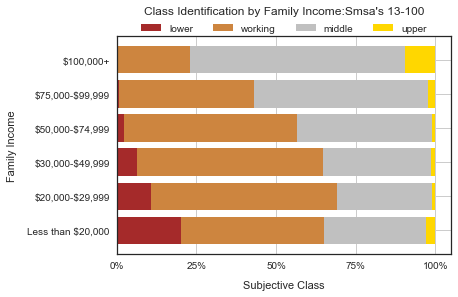

In [33]:
# Graph of Smsa's 13-100
income_range_names = ['Less than \$20,000', '\$20,000-\$29,999', '\$30,000-\$49,999', '\$50,000-\$74,999', '\$75,000-\$99,999', '\$100,000+']
labels = ['upper', 'middle', 'working', 'lower']
create_bar_graph(cms[1], income_range_names, labels, 'Subjective Class', 'Family Income', 'Class Identification by Family Income:Smsa\'s 13-100')

Most respondents living in Standard Metropolitan Statistical Areas identify as working or middle class, which is similar to Figure 1 in the "Data Validation" section. In fact, the distributions of subjective class for each income range for Smsa's 13-100 are, in general, very similar to distributions for all respondents.  

### Figure 2: Suburb, 13-100

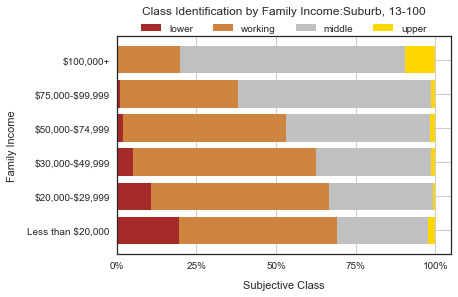

In [34]:
# Graph of Suburb, 13-100
income_range_names = ['Less than \$20,000', '\$20,000-\$29,999', '\$30,000-\$49,999', '\$50,000-\$74,999', '\$75,000-\$99,999', '\$100,000+']
labels = ['upper', 'middle', 'working', 'lower']
create_bar_graph(cms[3], income_range_names, labels, 'Subjective Class', 'Family Income', 'Class Identification by Family Income:Suburb, 13-100')

The distributions of subjective class for each income range for Suburb, 13-100 are very similar to the distributions for all respondents and Smsa's 13-100. There doesn't seem to be a difference between urban and suburban respondents. 

### Figure 3: Other Rural

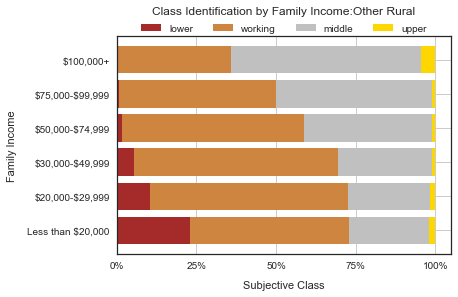

In [35]:
# Graph of Other Rural
income_range_names = ['Less than \$20,000', '\$20,000-\$29,999', '\$30,000-\$49,999', '\$50,000-\$74,999', '\$75,000-\$99,999', '\$100,000+']
labels = ['upper', 'middle', 'working', 'lower']
create_bar_graph(cms[5], income_range_names, labels, 'Subjective Class', 'Family Income', 'Class Identification by Family Income:Other Rural')

Compared to the urban and suburban figures, Other Rural have higher proportions of working class in all income ranges. This difference is most prominent in the three highest income ranges. For example, in the \$100,000+ income range, the proportion of working class is around 23% for all respondents compared to around 40% for rural respondents.  

After comparing the three different figures representing respondents from urban, suburban, and rural locations, I found that Smsa 13-100 and Suburb 13-100 have similar distributions. The biggest difference can be seen in the Other Rural group with higher proportions of working class. This may be due to the types of jobs associated with rural areas. 

## Concluding Remarks

The main conclusions from this notebook include:
- Income is not the only factor that Americans associate with class. This finding connects to the idea of "status inconsistencies" in which Americans have flexible, and even multiple, class identities depending on which settings they are in. 
- Most respondents consider themselves to be either working or middle class. This might be especially true for respondents with incomes near the cutoff values. 
- The method of dealing with income data has an impact on the distribution of subjective class for different income ranges. Specifically, adjustment for household size is important and should be applied to make incomes more comparable.
- The distribution of subjective class is different from the distributions of (1) opinion on family income and (2) financial satisfaction. All three variables are affected by income.
- The distribution of subjective class between urban and suburban groups are similar. However, respondents living in rural areas are more likely to identify themselves as working class compared to respondents living in urban or suburban areas.  

Some potential next steps include:
- Apply household size adjustment to the rest of Hout's analysis. 
- Conduct multinormal logistic regression to see what factors have the most impact on subjective class.
- Identify which classes the respondents with incomes that are not clearly above or below the median identify as. 